## Extreme value analysis for Boston tide gauge

In [1]:
"""
:Project:   boston-tides
:Created:   Tue Oct 19 16:14:49 2021
:Filename:  boston_gev.ipynb

Generalized Extreme Value (GEV) analysis for Boston tide gauge using block maxima
and Markov chain Monte Carlo. Based on pyextremes tutorial by Georgii Bocharov:
https://github.com/georgebv/pyextremes-notebooks/blob/master/notebooks/EVA%20basic.ipynb
"""
__version__ = "0.0.1"
__author__ = "Perry Oddo <perry.oddo@nasa.gov>"

In [2]:
import pickle
import random
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pyextremes import EVA

random.seed(10)
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

### Download and Process Data

In [3]:
# Download hourly data from NOAA Tides and Currents
#from data import get_noaa_data

In [4]:
# Read in downloaded time series
df_hourly = pd.read_csv("data/boston_hourly_msl.csv",
                        parse_dates=["date_time"], 
                        index_col=["date_time"]
                       )
                       
# Create hourly datetime index from beginning of record to present
target_dates = pd.date_range("19210504", "20211001", closed="left", freq="H")

# Reindex data frame to account for missing records
df_hourly = df_hourly.reindex(target_dates)
df_hourly = df_hourly.dropna()

df_hourly.head()

,water_level,sigma,flags
1921-05-04 00:00:00,3.566,0.0,"0,0"
1921-05-04 01:00:00,3.810,0.0,"0,0"
1921-05-04 02:00:00,3.657,0.0,"0,0"
1921-05-04 03:00:00,3.322,0.0,"0,0"
1921-05-04 04:00:00,2.804,0.0,"0,0"


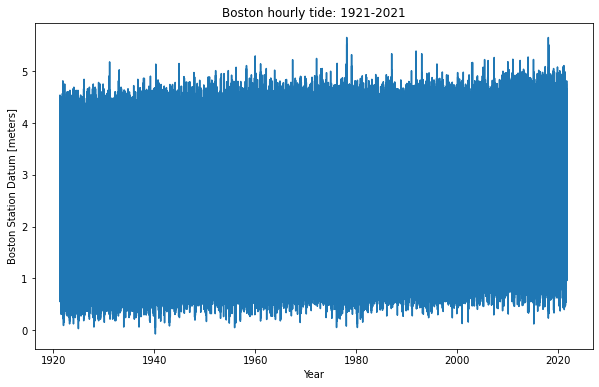

In [5]:
# Plot full record
plt.plot(df_hourly.water_level)
plt.xlabel("Year")
plt.ylabel("Boston Station Datum [meters]")
plt.title("Boston hourly tide: 1921-2021")
plt.show()

In [6]:
# Detrend linear signal
lin_fit = np.poly1d(np.polyfit(range(0,len(df_hourly.index)), df_hourly.water_level, 1))     

# De-trend record
detrended = df_hourly.water_level - lin_fit(range(0,len(df_hourly.index)))
df_hourly["detrended"] = detrended

df_hourly.head()

,water_level,sigma,flags,detrended
1921-05-04 00:00:00,3.566,0.0,"0,0",1.089211
1921-05-04 01:00:00,3.810,0.0,"0,0",1.333211
1921-05-04 02:00:00,3.657,0.0,"0,0",1.180211
1921-05-04 03:00:00,3.322,0.0,"0,0",0.845210
1921-05-04 04:00:00,2.804,0.0,"0,0",0.327210


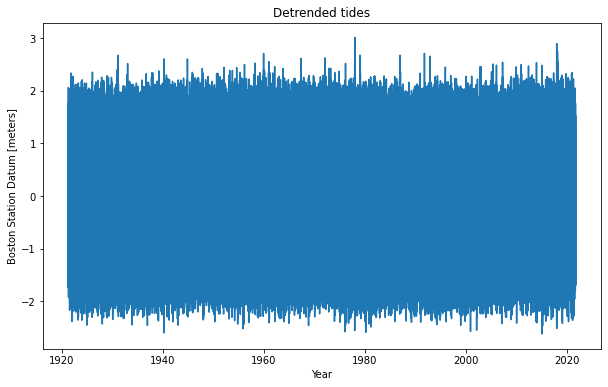

In [7]:
# Plot detrended record
plt.plot(df_hourly.detrended)
plt.xlabel("Year")
plt.ylabel("Boston Station Datum [meters]")
plt.title("Detrended tides")
plt.show()

### Perform Extreme Value Analyis

In [8]:
# Initialize EVA object
eva_data = df_hourly.detrended.squeeze()
model = EVA(data=eva_data)
model

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                     detrended      Size:                             870,079
Start:                           May 1921      End:                       September 2021
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Extreme values have not been extracted
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fit to the extremes

                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                     detrended      Size:                             870,079
Start:                           May 1921      End:                       September 2021
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                101      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model has not been fi

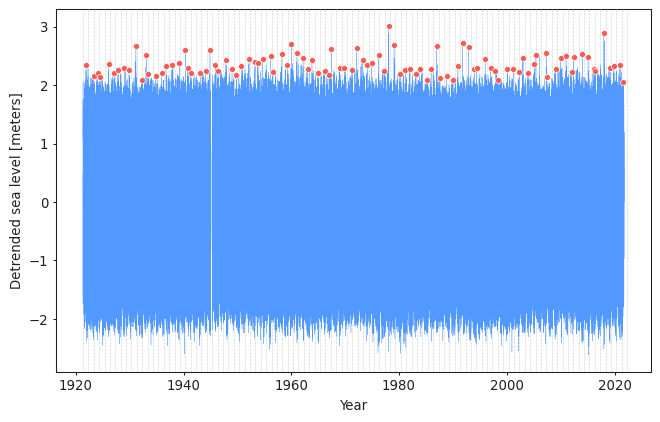

In [9]:
# Extract extreme values by annual block maxima approach
model.get_extremes(
    method="BM",
    extremes_type="high",
    block_size="365.2425D",
    errors="raise",
)
print(model)

# Plot block maxima
model.plot_extremes()
plt.xlabel("Year")
plt.ylabel("Detrended sea level [meters]")
#plt.savefig("plots/gev/1_annual_block_maxima.png")
plt.show()

In [10]:
# Fit the model extremes to GEV distribution using MCMC
model.fit_model(
    model="Emcee",
    #model = "MLE", # alternate model 
    distribution="genextreme",
    n_samples = 10_000,
    progress=True
)
print(model)

# Save model to file
with open("outputs/eva_model.pkl", "wb") as _:
    pickle.dump(model, _)

100%|██████████| 10000/10000 [07:08<00:00, 23.32it/s]


                           Univariate Extreme Value Analysis                            
                                      Source Data                                       
----------------------------------------------------------------------------------------
Data label:                     detrended      Size:                             870,079
Start:                           May 1921      End:                       September 2021
                                     Extreme Values                                     
----------------------------------------------------------------------------------------
Count:                                101      Extraction method:                     BM
Type:                                high      Block size:             365 days 05:49:12
                                         Model                                          
----------------------------------------------------------------------------------------
Model:               

In [11]:
# Show summary of model return levels
summary = model.get_summary(
    return_period=[1, 2, 5, 10, 25, 50, 100, 250, 500, 1000],
    alpha=0.95
)
summary

/home/poddo/.conda/envs/gev/lib/python3.7/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,return value,lower ci,upper ci
return period,,,
1.0,-1.993754,NaN,1.612497
2.0,2.319191,2.286698,2.354915
5.0,2.477115,2.434003,2.540807
10.0,2.584843,2.529012,2.687875
25.0,2.724677,2.641944,2.913214
50.0,2.831166,2.719611,3.113206
100.0,2.939246,2.791365,3.343992
250.0,3.085251,2.878409,3.703558
500.0,3.198353,2.938709,4.025146


### Visualize results

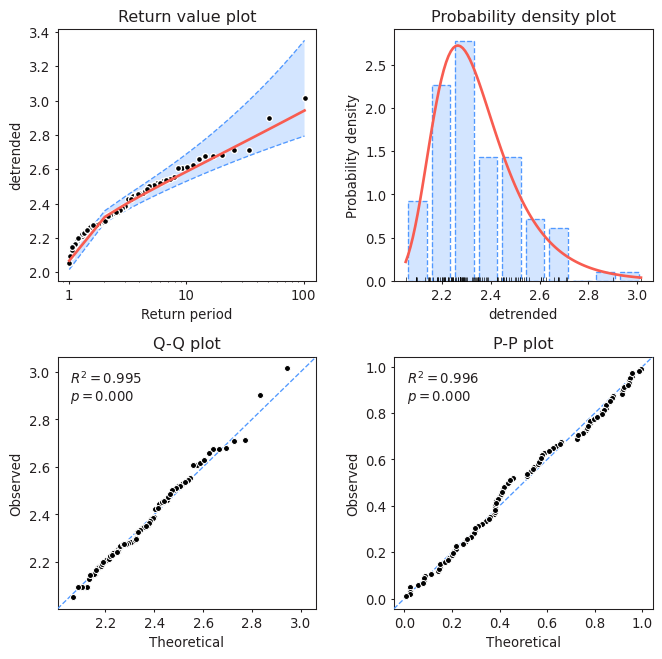

In [12]:
# Diagnostic plot
model.plot_diagnostic(alpha=0.95)
#plt.savefig("plots/gev/2_gev_diagnostic_plots.png")
plt.show()

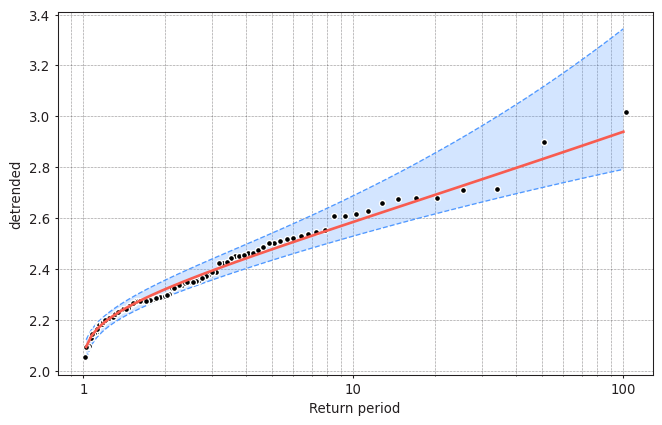

In [13]:
# Plot return values
model.plot_return_values(
    return_period=np.logspace(0.01, 2, 100),
    return_period_size="365.2425D",
    alpha=0.95,
)
#plt.savefig("plots/gev/3_return_values.png")
plt.show()

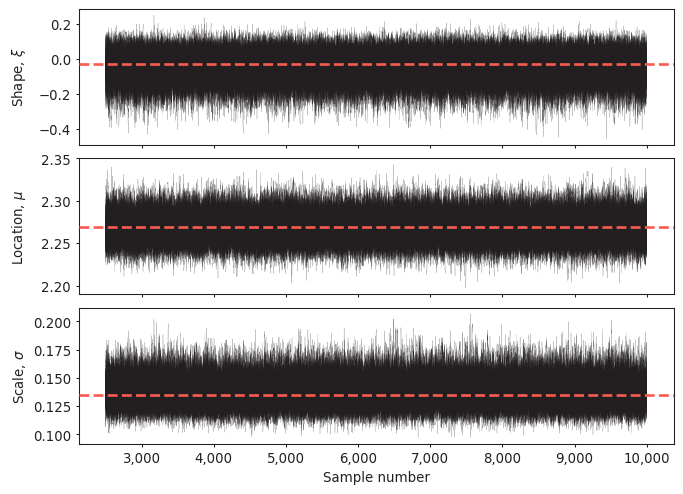

In [14]:
# MCMC training trace plots
burn_length = 2500

model.plot_trace(
    burn_in=burn_length
)
#plt.savefig("plots/gev/4_mcmc_trace_plots.png")
plt.show()

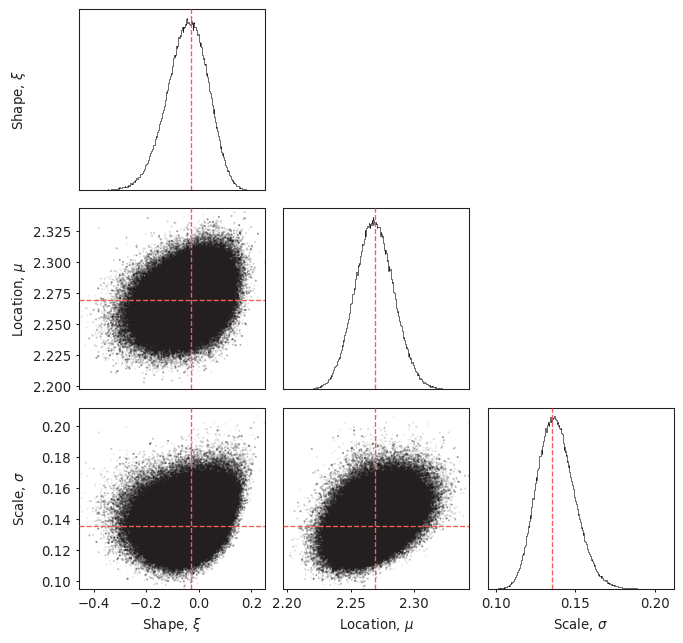

In [15]:
# GEV parameter distributions
model.plot_corner()
#plt.savefig("plots/gev/5_gev_param_dists.png")
plt.show()

In [16]:
# Extract values for parameter distributions
gev_trace = model.model.trace
burn_length = 2500

shape = gev_trace[:, burn_length:, 0].flatten()
location = gev_trace[:, burn_length:, 1].flatten()
scale = gev_trace[:, burn_length:, 2].flatten()

# Create data frame for parameter distributions
gev_df = pd.DataFrame({
    "Shape": shape,
    "Location": location,
    "Scale": scale
})

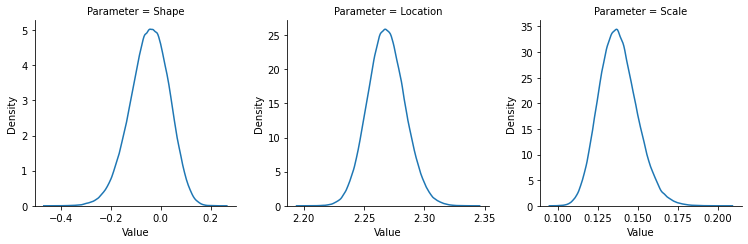

In [17]:
# Melt data frame
gev_df_long = pd.melt(gev_df,
                      value_vars=["Shape", "Location", "Scale"],
                      var_name="Parameter", value_name="Value")

# Plot kernel density estimates
g = sns.FacetGrid(gev_df_long, 
                  height=3.5,
                  col="Parameter", 
                  sharex=False,
                  sharey=False)
g.map(sns.kdeplot, "Value")
#plt.savefig("plots/gev/6_parameter_kde.png")
plt.show()